In [9]:
from collections import defaultdict
from random import randint, choice, random
from tqdm import tqdm
from itertools import permutations

class Grafo():
    """
    Classe genérica para grafos, com métodos como menor caminho entre pontos A e B
    """

    def __init__(self) -> None:
        self.adj = defaultdict(dict)
        self.densidade = None


    def contarArestas(self, adj):
        return sum([len(adj[v]) for v in adj]) / 2 # Divisão por dois porque cada aresta é contada duas vezes (ida e volta)

    def vertices(self):
        return set(self.adj.keys())

    def popularAutomaticamente(self, vertices, arestas, intervalo=(1,10)):
        """
        Cria um grafo não-direcional com os vertices e arestas.
        @param vertices: int, str ou list;
            Traz os vértices que serão usados no grafo
                        int -> Os vértices serão gerados por range(vertices)
                        str -> serão usados os caracteres da string.
                                -> Aceita apenas a-zA-Z, e descarta valores duplicados.
                        list -> serão usados os elementos da lista. Descarta valores duplicados.
                                -> Devem ser hasable items, para serem transformados em set.
                        set -> Os elementos do set serão a lista
        @param arestas: float, 0 < x <= 1; 
            Representa a densidade de arestas a serem geradas automaticamente. 
            O número real será o primeiro valor possível >= ao valor informado.
            O grafo será completamente ligado, então o número mínimo de arestas é vertices-1, e o máximo é vertices!
        @param intervalo: tupla no formato (min, max) (inclusivos) para gerar aleatoriamente as distâncias entre os vértices.
        """

        if len(self.adj) != 0:
            raise Exception('O grafo já está populado. Use .limparGrafo() para apagar todo o conteúdo deste objeto.')
        
        # Transformando os vértices em set, para poder iterar sobre;
        # apesar de virarem as chaves de um dict depois, garantir que sejam hashable e remover duplicidades é bom.
        if type(vertices) == int:
            vertices = set([x for x in range(vertices)])
        elif type(vertices) == str:
            vertices = set([x for x in vertices])
        elif type(vertices) == list:
            vertices = set(vertices)
        elif type(vertices) == set:
            pass
        else:
            raise TypeError(f'Variável do tipo {type(vertices)} não é aceita. Esperava int, str ou list')

        # Dict com as listas vazias
        adj = {v:{} for v in vertices}

        # Populando até a densidade
        maxArestas = sum(range(len(vertices)))/2 # Porque como é não-direcional, serão contadas duas vezes
        minArestas = len(vertices)-1
        minPct = minArestas/maxArestas
        if minPct > arestas:
            arestas = minPct # Garantindo que o grafo será completo, quando usado com o sorted abaixo.
        #print(f'maxArestas: {maxArestas}')
        curPct = self.contarArestas(adj)/maxArestas
        #print(f'{curPct} < {arestas}')

        # Fazendo a população inicial A->B->....->N, para garantir que o grafo é conectado
        verticesSequenciais = list(vertices)
        for i in range(len(vertices)-1):
            distancia = randint(*intervalo)
            adj[verticesSequenciais[i]][verticesSequenciais[i+1]] = distancia
            adj[verticesSequenciais[i+1]][verticesSequenciais[i]] = distancia

        while curPct < arestas:
            # Escolhendo o primeiro dos valores

            A = sorted(vertices, key = lambda x: len(adj[x]))[0] # Pego um dos que tem menos, para distribuir melhor
            if len(adj[A].keys()) == len(vertices):
                A = sorted(vertices, key = lambda x: len(adj[x]), reverse=True)[0] # Pego um dos que tem menos, para distribuir melhor
            possiveisB = vertices - set(adj[A].keys())
            possiveisB.remove(A)
            B = choice(list(possiveisB))
            distancia = randint(*intervalo)
            adj[A][B] = distancia
            adj[B][A] = distancia
            
            curPct = self.contarArestas(adj)/maxArestas
            #print(f'{curPct} = {self.contarArestas(adj)}/{maxArestas}')
            #pprint(adj)
            #print(f'{curPct} < {arestas} = {curPct < arestas}')
            #input()
        self.adj = adj
            

        #Implementing Dijkstra's Algorithm
    def dijkstra(self, inicial):
        visited = {inicial : 0}
        path = defaultdict(list)

        nodes = set(self.adj.keys()) # set(graph.nodes)

        while nodes:
            minNode = None
            for node in nodes:
                if node in visited:
                    if minNode is None:
                        minNode = node
                    elif visited[node] < visited[minNode]:
                        minNode = node
            if minNode is None:
                break

            nodes.remove(minNode)
            currentWeight = visited[minNode]

            for edge in self.adj[minNode]:
                weight = currentWeight + self.adj[minNode][edge]
                if edge not in visited or weight < visited[edge]:
                    visited[edge] = weight
                    path[edge].append(minNode)
        
        return visited, path

    def preencherMenoresCaminhos(self):
        self.menoresDistancias={}
        self.melhorCaminho={}
        for v in self.vertices():
            self.menoresDistancias[v], self.melhorCaminho[v] = self.dijkstra(v)

    def caminho(self,x,y):
        try:
            cam = []
            while True:
                cam.append(x)
                if x == y:
                    return cam[::-1]
                x = self.melhorCaminho[y][x][0]
                
        except:
            print(self.melhorCaminho[x])
            raise Exception(f'x = {x},y = {y}')

    def MMC(self, paradas, chance = 1.):
        """
        Mínimo Melhor Caminho para passar por todas as paradas
        """
        primeiro = paradas[0]
        outras = paradas[1:]

        perms = permutations(outras)
        distanciaFinal = False
        finalPerm = None
        for perm in perms:
            perm = [primeiro] + list(perm)
            #print(perm)
            distancia = 0
            for i in range(len(perm)-1):
                distancia += self.menoresDistancias[perm[i]][perm[i+1]]
                #print(self.menoresDistancias[perm[i]][perm[i+1]],end='+')
            if not distanciaFinal:
                finalPerm = perm
                distanciaFinal = distancia
            else:
                if random() > chance:
                    return distanciaFinal, finalPerm

                if distancia < distanciaFinal:
                    distanciaFinal = distancia
                    finalPerm = perm
            #print(f'={distancia}')
        return distanciaFinal, finalPerm

    def itinerario(self, rota):
        itinerario = [rota[0]]
        for i in range(len(rota)-1):
            itinerario = itinerario + self.caminho(rota[i],rota[i+1])[1:]
        return itinerario

In [139]:
from random import choice, shuffle, choices
import copy
from tqdm import tqdm
from math import ceil
import pandas as pd
from datetime import datetime as time

class Pacote():
    """
    Item com nome, descrição, origem e destino
    """

    def __init__(self, origem, destino, grafo, nome='Nome Generico', desc='Pacote Generico') -> None:
        """
        @param origem: Nó de origem do 
        @param nome: String para identificar pacote. Puramente estético
        @param desc: Descrição do pacote. Puramente estético
        """
        self.nome = nome
        self.desc = desc
        self.origem = origem
        self.destino = destino
        self.grafo = grafo
        self.caminho = grafo.caminho(origem,destino)
        self.hash = str(self.origem) + '$' + str(self.destino)
        self.distancia = grafo.menoresDistancias[origem][destino]

    def __repr__(self) -> str:
        return f'{str(self.origem)} -> {str(self.destino)}'

    def copy(self):
        newone = type(self)(self.origem, self.destino, self.grafo)
        newone.__dict__.update(self.__dict__)
        return newone 
        


class Caminhao():
    """
    Cromossomo do nosso algoritmo genético
    """

    def __init__(self, pacotes, grafo, capacidade = 50, curMMC = None) -> None:
        self.pacotes = pacotes
        self.capacidade = capacidade
        self.grafo = grafo
        if curMMC is None:
            curMMC = self.grafo.MMC(list(self.getParadas()),.4)
            self.melhorCaminho = curMMC[1]
        else:
            self.melhorCaminho = curMMC

    def __str__(self):
        resposta = {'pacotes':self.pacotes,
                    'capacidade':self.capacidade,
                    'melhorCaminho':self.melhorCaminho,
                    'getParadas':self.getParadas(),
                    'getItinerario':self.getItinerario(),
                    'getDistancia':self.getDistancia()}
        return str(resposta)

    def copy(self):
        copiaPacotes = [pacote.copy() for pacote in self.pacotes]
        newone = type(self)(copiaPacotes,self.grafo, self.capacidade, self.melhorCaminho)
        return newone 

    def atualizarMelhorCaminho(self):
        # Essa função é chamada aqui, em vez de um método, porque tem um componente aleatório
        paradas = list(self.getParadas())
        if len(paradas) == 0:
            self.melhorCaminho = None
        else:
            curMMC = self.grafo.MMC(paradas,.4)
            self.melhorCaminho = curMMC[1]

    def npacotes(self):
        return len(self.pacotes)

    def espacoLivre(self):
        return self.capacidade - self.npacotes()
        
    def getNumPacotesUnicos(self):
        hashes = [pacote.hash for pacote in self.pacotes]
        hashesUnicos = set(hashes)
        return len(hashesUnicos)

    def getPctPacotesUnicos(self):
        if self.npacotes() == 0:
            return 0
        return self.getNumPacotesUnicos()/self.npacotes() # Este número tem que diminuir


    def getParadas(self):
        """
        Todos os pontos únicos pelos quais o caminhão precisa passar para entregas
        """
        paradas = set()
        for pacote in self.pacotes:
            paradas.add(pacote.origem)
            paradas.add(pacote.destino)
        return paradas

    def getItinerario(self):
        if self.melhorCaminho is None:
            return None
        return self.grafo.itinerario(self.melhorCaminho)

    def getDistancia(self):

        if self.getItinerario() is None:
            return 0
        total = 0
        for i in range(len(self.getItinerario())-1):
            x, y = self.getItinerario()[i], self.getItinerario()[i+1]
            total += self.grafo.menoresDistancias[x][y]
        return total # Este número tem que diminuir


class ConjuntoDeCaminhoes():
    def __init__(self, frota, pacotes) -> None:
        self.pacotes = pacotes
        if len(frota) < 1:
            raise ValueError('A lista não pode estar vazia.')
        self.frota = frota

    def copy(self):
        copiaPacotes = []
        copiaCaminhoes = {i:self.frota[i].copy() for i in self.frota}
        for i in copiaCaminhoes:
            copiaPacotes.append(copiaCaminhoes[i].pacotes)

        newone = type(self)(copiaCaminhoes, copiaPacotes)
        return newone 
        
    def getDistanciaTotal(self):
        return sum([caminhao.getDistancia() for caminhao in self.frota.values()])
        #self.distanciaTotal = sum([caminhao.getDistancia() for caminhao in self.frota.values()])

    def adicionarPacoteAleatoriamente(self, pacote):
        caminhaoAleatorio = choice(self.frota.keys())
        caminhaoAleatorio.append(pacote)
        caminhaoAleatorio.atualizarMelhorCaminho()

class AGPI3():
    def __init__(self) -> None:
        self.fitnessGeracoes = {}        
        self.curGeracao = 0

    def gerarGrafo(self, vertices, arestas, intervalo=(1,10)):
        self.grafo = Grafo()
        self.grafo.popularAutomaticamente(vertices, arestas, intervalo)
        self.grafo.preencherMenoresCaminhos()

    def gerarPacotes(self, nPacotes=40, origem = None):
        pacotes = []
        for _ in range(nPacotes):
            
            if origem is None:
                origem = choice(list(self.grafo.vertices()))
            destino = choice(list(self.grafo.vertices()))
            curPacote = Pacote(origem, destino, self.grafo)
            pacotes.append(curPacote)
        return pacotes

    def gerarCaminhao(self, pacotes, capacidade = 50):
        caminhao = Caminhao(pacotes,self.grafo, capacidade = 50)
        return caminhao

    def gerarIndividuo(self, n_caminhoes, pacotes = None, origem = None, capacidade = 50):
        
        if type(pacotes) == int:
            pacotes = self.gerarPacotes(nPacotes=pacotes, origem=origem)
        elif type(pacotes) != list:
            raise(f'O tipo {type(pacotes)} não é aceito para a variável pacotes. Esperado: int, list')
        individuo = {i:self.gerarCaminhao(pacotes[i::n_caminhoes], capacidade) for i in range(n_caminhoes)}
        return ConjuntoDeCaminhoes(individuo, pacotes)

    def gerarPopulacao(self, n_individuos, n_caminhoes, pacotes = None, origem=None, capacidade = 50):
        pop = []
        for _ in tqdm(range(n_individuos)):
            pop.append(self.gerarIndividuo(n_caminhoes,pacotes=pacotes,origem=origem, capacidade = capacidade))
        self.pop = pop
        # Reset desses valores ao gerar nova população, pra poder usar o mesmo conjunto de pacotes.
        self.fitnessGeracoes = {}        
        self.curGeracao = 0


    # CLASSES DE TREINAMENTO
    def fitness(self, ind):
        # Para o caminhao -> diminuir o percentual único
        # Para o individuo -> diminuir a distanciaTotal
        
        somaPctUnico = sum([caminhao.getPctPacotesUnicos() for caminhao in ind.frota.values()])
        nCaminhoes = len(ind.frota)
        somaPonderada = somaPctUnico/nCaminhoes

        listaParadas = [caminhao.getParadas() for caminhao in ind.frota.values() if caminhao.getParadas()]
        intersection = set.intersection(*listaParadas)
        union = set.union(*listaParadas)
        pctIntersection = len(intersection)/len(union)
        result = ind.getDistanciaTotal() * (1 + somaPonderada/5 + pctIntersection/5)
        #print(f'{ind.getDistanciaTotal():.2f} * (1 + {somaPonderada:.2f} + {pctIntersection:.2f}) = {result:.2f}')
        #return ind.getDistanciaTotal()
        return result

    def crossover(self, caminhao1, caminhao2, origem = None):
        for p1 in caminhao1.getParadas():
            if p1 == origem:
                continue
            if p1 in caminhao2.getParadas():
                for i,pacote in enumerate(caminhao2.pacotes):
                    if caminhao1.espacoLivre() < 1:
                        break
                    if (pacote.origem == p1) or (pacote.destino == p1):
                        troca = caminhao2.pacotes.pop(i)
                        caminhao1.pacotes.append(troca)
        #print(f'Caminhao 1:')
        #print(caminhao1)
        caminhao1.atualizarMelhorCaminho()
        #print(f'Caminhao 2:')
        #print(caminhao2)
        caminhao2.atualizarMelhorCaminho()

    def mutacao(self, caminhao):
        if caminhao.melhorCaminho is not None:
            if len(caminhao.melhorCaminho) > 3:    
                comeco = caminhao.melhorCaminho[0]
                fim = caminhao.melhorCaminho[-1]
                to_shuffle = caminhao.melhorCaminho[1:-1]
                shuffle(to_shuffle)
                caminhao.melhorCaminho = [comeco] + to_shuffle + [fim]


    def individuoMutacao(self, cjDeRotas):
        #print([cam.melhorCaminho for cam in cjDeRotas.frota.values()])
        start = time.now()
        #cur = copy.deepcopy(cjDeRotas)
        cur = cjDeRotas.copy()
        end = time.now()
        #print('>>[MUTACAO]cur = copy.deepcopy(cjDeRotas) ',end-start)
        start = end
        #print([cam.melhorCaminho for cam in cur.frota.values()])
        chosenIndex = choice([x for x in cur.frota])
        self.mutacao(cur.frota[chosenIndex])
        end = time.now()
        #print('>>[MUTACAO]self.mutacao(cur.frota[chosenIndex]) ',end-start)
        start = end
        #print([cam.melhorCaminho for cam in cur.frota.values()])
        return cur

    def individuoCrossover(self, cjDeRotas, origem = None):
        #print([cam.getParadas() for cam in cjDeRotas.frota.values()])
        start = time.now()
        #cur = copy.deepcopy(cjDeRotas)
        cur = cjDeRotas.copy()
        end = time.now()
        #print('>>[CROSSOVER]cur = copy.deepcopy(cjDeRotas) ',end-start)
        start = end
        #print([cam.getParadas() for cam in cur.frota.values()])
        chosenIndex1 = choice([x for x in cur.frota])
        chosenIndex2 = choice([x for x in cur.frota])
        while chosenIndex1 == chosenIndex2:
            chosenIndex2 = choice([x for x in cur.frota])
        end = time.now()
        #print('>>[CROSSOVER]while chosenIndex1 == chosenIndex2: ',end-start)
        start = end
        self.crossover(cur.frota[chosenIndex1],cur.frota[chosenIndex2],origem)
        end = time.now()
        #print('>>[CROSSOVER]self.crossover(cur.frota[chose...: ',end-start)
        start = end
        #print([cam.getParadas() for cam in cur.frota.values()])
        return cur

    def proxGeracao(self, origem = None):
        start = time.now()
        curPop = self.pop        
        n_individuos = len(self.pop)
        
        if len(self.fitnessGeracoes) == 0:
            # Esse if é pra preencher o fitness da geração 0 antes de começar
            fitnessInicial = [self.fitness(ind) for ind in curPop]
            self.fitnessGeracoes[self.curGeracao] = fitnessInicial
            self.curGeracao += 1
        end = time.now()
        #print('if len(self.fitnessGeracoes) == 0:',end-start)
        start = end
        
        # Parte das mutações
        mutacoesPop = [self.individuoMutacao(ind) for ind in curPop]
        end = time.now()
        #print('mutacoesPop = [self.individuoMutacao(ind) for ind in curPop] ',end-start)
        start = end
        # Parte dos crossover
        crossoverPop = [self.individuoCrossover(ind, origem) for ind in curPop]
        end = time.now()
        #print('crossoverPop = [self.individuoCrossover(ind, origem) for ind in curPop] ',end-start)
        start = end
        conjuntoAtual = curPop + mutacoesPop + crossoverPop

        # Pegando os valores de fitness
        fitnessConjuntoAtual = [ceil(self.fitness(ind)) for ind in conjuntoAtual]
        #print(len(fitnessConjuntoAtual))
        weights = [(1+abs(max(fitnessConjuntoAtual)-fitness))**3 for fitness in fitnessConjuntoAtual] # O 1+ é para evitar que fique tudo 0 quando ficarem iguais.
        end = time.now()
        #print('weights = [(1+abs(max(fit... ',end-start)
        start = end
        
        #print('weights: ',weights)
        #print('fit: ',fitnessConjuntoAtual)
        #print('#',self.curGeracao)
        
        newPop = [choices(conjuntoAtual,weights=weights,k=1)[0] for _ in range(n_individuos)]
        fitnessAtual = [self.fitness(ind) for ind in newPop]
        #print('fitNewPop: ',fitnessAtual)
        self.fitnessGeracoes[self.curGeracao] = fitnessAtual
        self.curGeracao += 1
        end = time.now()
        #print('self.curGeracao += 1 ',end-start)
        start = end
        
        self.pop = newPop
        
    def Evoluir(self, n_geracoes=None, max_geracoes=None, min_variacao=None, strikes = 3, testNum = 10, origem = None):
        """
        Dois modos:
            Passando n_geracoes -> roda n_geracoes vezes, sem distinção.
            Passando max_geracoes + min_variacao -> Para assim que  OU houver variação no valor mínimo do fitness entre gerações MENOR que min_variação,
                                                                    OU houver max_geracoes iteracoes

            A preferência é dada para o primeiro método; Se n_geracoes é passado, os outros atributos são ignorados.
        """
        start = time.now()
        if n_geracoes is not None:
            for _ in tqdm(range(n_geracoes)):
                self.proxGeracao(origem)
                #print(min(self.fitnessGeracoes[self.curGeracao-1]))
            end = time.now()
            #print('if n_geracoes is not None:',end-start)
            start = end
        else:
            if (max_geracoes is None) or (min_variacao is None):
                raise Exception(f'Como você não passou n_geracoes, max_geracoes e min_variacao não podem ser nulos.')
            strike = 0
            #for _ in tqdm(range(max_geracoes)):
            
            for _ in range(max_geracoes):
                self.proxGeracao(origem)
                end = time.now()
                #print('self.proxGeracao(origem):',end-start)
                start = end
                #print(self.curGeracao)
                #print(self.fitnessGeracoes.keys())
                # Essas atribuições podem ser feitas porque a primeira chamada de proxGeracao preenche os valores pras gerações 0 e 1
                for ind in self.pop:
                    #print([x.getParadas() for x in ind.frota.values()])
                    pass
                
                if self.curGeracao > testNum:
                    valorAnterior = sum(self.fitnessGeracoes[self.curGeracao-testNum])/len(self.fitnessGeracoes[self.curGeracao-testNum])
                    valorAtual = sum(self.fitnessGeracoes[self.curGeracao-1])/len(self.fitnessGeracoes[self.curGeracao-1])
                    #print(f'valorAnterior: {valorAnterior}; valorAtual: {valorAtual}')
                    variacao = abs(1- abs(valorAtual/valorAnterior))
                    end = time.now()
                    #print('if self.curGeracao > testNum:',end-start)
                    start = end
                else:
                    variacao = 1
                #print('Var: ',variacao)
                #print(f'Strike: {strike}')
                if variacao < min_variacao:
                    strike += 1
                    if strike > strikes:
                        break
                else:
                    strike = 0


In [94]:
g = Grafo()
g.popularAutomaticamente(20,0.5)
g.preencherMenoresCaminhos()

In [30]:
p1 = Pacote(0,1,g)

In [140]:
import pickle
resultados = []
for capacidade in range(5,41,5): #8
    for vertices in range(40,600,50): # 12
        for npacotes in range(50,1000,150): # 7
            for n_individuos in range(5,20,5): # 3
                for min_variacao in [0.001,0.005,0.01,0.05]: # 4
                    for arestas in [0.3,0.5,0.8]: # 3
                        for strikes in range(3,13,3): #4
                            try:
                                origem = 0
                                paiDeTodos = AGPI3()
                                paiDeTodos.gerarGrafo(vertices=vertices,arestas=arestas)
                                pacotes = paiDeTodos.gerarPacotes(npacotes,origem)
                                max_geracoes = 500
                                n_caminhoes = ceil(1.2*(npacotes/capacidade))
                                resDict = {
                                    'max_geracoes':max_geracoes,
                                    'capacidade':capacidade,
                                'vertices':vertices,
                                'npacotes':npacotes,
                                'n_individuos':n_individuos,
                                'n_caminhoes':n_caminhoes,
                                'min_variacao':min_variacao,
                                'strikes':strikes}
                                start = time.now()
                                paiDeTodos.gerarPopulacao(n_individuos=n_individuos,n_caminhoes=n_caminhoes,pacotes=pacotes, capacidade = capacidade)
                                resDict['pop'] = [cjDeRotas.copy() for cjDeRotas in paiDeTodos.pop]
                                paiDeTodos.Evoluir(max_geracoes=max_geracoes, min_variacao=min_variacao, strikes = strikes, origem = origem)
                                end = time.now()
                                resDict['delta'] = end-start
                                resDict['fitnessGeracoes'] = paiDeTodos.fitnessGeracoes.copy()
                                resDict['grafo'] = paiDeTodos.grafo
                                timestamp = str(time.now()).split('.')[0].replace('-','').replace(':','').replace(' ','')
                                with open(f'resultados/{timestamp}.pkl','wb') as f:
                                    pickle.dump(resDict,f)
                            except:
                                resDict = {
                                    'max_geracoes':max_geracoes,
                                    'capacidade':capacidade,
                                'vertices':vertices,
                                'npacotes':npacotes,
                                'n_individuos':n_individuos,
                                'n_caminhoes':n_caminhoes,
                                'min_variacao':min_variacao,
                                'strikes':strikes}
                                print(resDict)

                            
                            


100%|██████████| 5/5 [00:00<?, ?it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 5/5 [00:00<00:00, 4976.63it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 5/5 [00:00<00:00, 5058.25it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 5/5 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 5/5 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 5162.86it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 5012.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 10318.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 10029.42it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 10027.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 10027.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 10019.84it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 9864.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 10072.78it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 10015.05it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 10220.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 10003.11it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 15511.48it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 15051.33it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 7598.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 7523.87it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 14416.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 15040.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 15040.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 15062.14it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 15036.94it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 5315.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 15484.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 15047.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 7520.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 7518.47it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 8235.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 5012.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 2506.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 5161.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 5008.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 5166.67it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 5012.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 5027.94it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2542.62it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 2541.39it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 5125.00it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2507.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 5025.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 2516.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2513.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2507.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 2494.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 5098.84it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2542.62it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 2538.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 5164.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 5108.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2545.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 2542.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 4984.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2516.99it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 5166.67it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2553.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2507.06it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2507.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3351.96it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 3351.42it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 5096.98it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2531.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 5014.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 3376.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 4944.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 3374.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3350.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 3382.78it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 5096.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 3376.51it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3342.87it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 4992.62it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 5040.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2963.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2512.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 3351.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 3375.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 3387.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3337.55it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 5090.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 5014.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3331.99it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 3349.28it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 3394.00it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 3381.41it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3341.81it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2512.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 5004.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3345.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 3354.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 5017.51it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3769.14it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3760.58it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3771.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3456.84it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3742.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3740.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2970.33it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3638.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3773.67it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3759.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3764.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3761.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3743.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3732.47it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3009.11it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3755.20it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3010.70it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 4998.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3786.61it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3759.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3786.84it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3758.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3793.00it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3019.95it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3759.68it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3727.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3733.58it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3761.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3752.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3739.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3747.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3753.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3008.25it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3015.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 4954.68it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3754.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 3013.01it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3780.70it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1687.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.05, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2546.63it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 2471.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1688.39it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2462.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1671.57it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 2506.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 2537.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2497.20it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1671.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1671.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1687.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1956.48it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1655.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1891.20it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 2506.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2563.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2473.06it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 2546.32it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1670.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1668.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1540.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1671.70it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1669.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1655.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2528.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 2538.62it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1994.25it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2005.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2534.48it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2016.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2006.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2017.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2004.06it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2489.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2002.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2020.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2002.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2508.25it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2010.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2011.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2511.41it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2000.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2004.93it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2005.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1645.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2524.41it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1990.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2506.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2506.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2270.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2502.12it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2507.06it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2004.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2003.11it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2024.96it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1998.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1662.16it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2008.19it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2511.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1998.62it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2006.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2288.47it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2492.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1880.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2151.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2148.94it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2505.66it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2149.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2156.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1872.23it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2217.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2149.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2148.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2294.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2146.52it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1877.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2500.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2157.12it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2148.43it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1630.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1871.90it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1886.55it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2499.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1886.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2682.01it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2145.28it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2156.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2148.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1670.99it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2149.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2504.96it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2155.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2160.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1963.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2080.44it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2154.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2148.87it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2506.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.05, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1255.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1656.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1671.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1670.90it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1008.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1671.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1694.26it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1253.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1252.55it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1249.12it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1704.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1250.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1250.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1257.66it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1253.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1608.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1251.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1651.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1251.06it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1265.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1245.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1253.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1250.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1244.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.05, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2002.44it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1419.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1433.85it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1669.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1682.16it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1435.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1646.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1434.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1299.47it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1668.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1666.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1431.99it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1671.10it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1679.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1259.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1663.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1430.92it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1424.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1256.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1671.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1661.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1660.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1424.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1681.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1248.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1662.23it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1661.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1671.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1417.52it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1432.14it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1673.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1668.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1674.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1672.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1504.05it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1672.95it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1508.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1671.66it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1505.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1503.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1364.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1669.88it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1669.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1671.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1498.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1504.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1086.51it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1671.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1650.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1878.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1671.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1502.83it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1504.74it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1501.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1669.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1505.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



  0%|          | 0/15 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 1669.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1669.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1663.66it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1664.80it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1511.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1577.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1670.99it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1873.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1667.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1663.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1245.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1262.43it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1008.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 998.41it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1248.90it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1255.78it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1253.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1001.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1089.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1001.98it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1253.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1229.50it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1253.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1252.70it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1264.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1242.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1240.55it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 996.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1244.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1433.61it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1247.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1253.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1114.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1249.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1433.61it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1253.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1114.20it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1107.23it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1252.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1247.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1254.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1255.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1114.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1253.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1114.05it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1002.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1110.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1432.58it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 6}



  0%|          | 0/10 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 1253.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1253.42it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1253.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1118.78it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1432.87it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1114.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1117.62it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1114.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1248.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1252.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.05, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1247.67it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.05, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1157.01it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1253.63it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1364.62it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1143.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1156.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1253.83it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1249.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1210.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1253.33it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1253.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1156.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1250.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1151.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1249.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1256.66it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1250.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1159.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1250.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1203.51it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1250.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1252.98it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1156.99it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1153.85it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1253.63it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1156.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1307.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1157.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1155.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 791.58it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1367.17it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1156.92it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1154.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1141.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1036.42it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1249.52it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1253.00it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 670.23it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 995.14it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 995.14it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1008.25it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 996.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1002.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 996.84it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1007.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 997.84it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 716.19it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 939.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1001.07it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 838.66it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 835.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1002.51it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 835.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1090.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1005.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 999.83it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1002.20it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 999.05it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 911.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 999.81it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1002.58it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 911.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1110.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1113.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 911.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1002.68it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1000.33it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 999.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 998.07it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1002.80it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1042.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1002.70it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 999.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 998.93it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 916.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 911.33it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1110.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 999.07it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 908.41it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 911.61it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 999.26it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 911.47it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1002.48it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1000.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 938.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1002.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 733.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 941.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 720.85it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1002.00it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 938.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1003.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1002.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 884.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1002.61it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1001.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1001.19it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1071.51it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 940.01it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 935.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 940.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1004.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1000.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1004.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 939.98it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1072.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 940.01it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1001.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1000.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1000.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 939.94it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 964.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 625.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 835.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 716.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 835.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 716.14it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 716.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 835.55it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 835.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 715.14it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 835.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 625.25it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 835.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 835.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 713.12it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 716.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 626.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 832.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 773.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 771.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 626.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 833.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



  0%|          | 0/10 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 10/10 [00:00<00:00, 835.44it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 715.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 528.68it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 717.51it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 773.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 771.32it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 715.87it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 771.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 769.39it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 838.04it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 716.19it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 783.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 909.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 909.49it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 716.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 834.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 835.57it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 770.90it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 835.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 751.98it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 791.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 833.90it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 854.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 835.57it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 791.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 834.23it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 883.05it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 835.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 835.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



  0%|          | 0/15 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 683.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 791.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 834.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 714.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 730.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 834.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 812.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 683.08it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 716.19it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 882.70it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 835.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 790.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 825.33it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 791.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 789.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 834.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 835.46it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 835.54it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 830.83it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 40, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 5160.31it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 5009.92it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 50, 'n_individuos': 5, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 9943.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 50, 'n_individuos': 10, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 14617.70it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.01, 'strikes': 12}


100%|██████████| 5/5 [00:00<00:00, 1393.27it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 2553.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 2512.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2506.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2493.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2516.68it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2508.25it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 2497.50it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 3301.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 3315.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3313.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 4965.44it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2506.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2508.11it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 4925.78it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 3314.35it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2489.94it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 3374.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2529.43it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3760.36it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3728.05it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3760.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3007.96it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 3008.68it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}



  0%|          | 0/15 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 3766.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2517.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3733.80it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2685.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3007.96it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 3730.26it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 3027.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2507.06it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 2510.06it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1670.90it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1651.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2481.98it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2203.01it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2485.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 2506.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1946.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1671.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1680.28it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2505.71it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 2469.85it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2005.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2016.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1673.97it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 2489.94it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 2002.05it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 2005.69it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1993.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2148.28it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2151.07it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1882.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2143.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2151.07it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 2148.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2149.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2137.70it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2138.79it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1254.80it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1766.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1880.07it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1879.67it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1880.18it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 2148.57it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1885.93it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 2148.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1253.25it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 2148.87it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1670.77it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1614.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1242.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1253.38it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1692.48it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1243.05it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 5/5 [00:00<00:00, 1253.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 3}



100%|██████████| 5/5 [00:00<00:00, 1002.03it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1660.91it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1426.20it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1671.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1253.23it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1431.85it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1662.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1671.37it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1439.86it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1358.61it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1503.33it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1670.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1503.80it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1495.15it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1492.85it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1366.76it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1664.45it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1499.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1256.81it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1669.84it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1509.65it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1504.02it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 751.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1665.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1495.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1499.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1366.96it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.01, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1244.82it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 996.75it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1242.24it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 1257.66it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1107.61it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1248.90it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1244.12it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1248.97it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 771.11it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 1243.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 772.63it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 1117.88it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1253.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1151.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1150.68it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1157.11it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1247.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 1157.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1156.52it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1151.63it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1076.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1036.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 1112.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 1002.56it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 5, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1003.81it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1004.00it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 1002.34it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 911.55it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 908.98it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 10/10 [00:00<00:00, 1002.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 1002.73it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1004.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 716.13it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1002.67it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 666.74it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 968.10it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 940.10it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 1006.94it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 997.52it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 858.93it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 1002.62it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.01, 'strikes': 9}


100%|██████████| 5/5 [00:00<00:00, 716.26it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 5/5 [00:00<00:00, 628.40it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 5/5 [00:00<00:00, 835.09it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 5, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 833.59it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 10/10 [00:00<00:00, 909.16it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 770.22it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 10/10 [00:00<00:00, 769.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 10/10 [00:00<00:00, 835.30it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 601.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 626.64it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}



100%|██████████| 15/15 [00:00<00:00, 834.42it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 790.21it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 791.60it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 835.53it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}



  0%|          | 0/15 [00:00<?, ?it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 791.29it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 3}



100%|██████████| 15/15 [00:00<00:00, 793.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 812.72it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 9}



100%|██████████| 15/15 [00:00<00:00, 793.89it/s]

{'max_geracoes': 500, 'capacidade': 5, 'vertices': 90, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.005, 'strikes': 12}



100%|██████████| 15/15 [00:00<00:00, 15047.73it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 50, 'n_individuos': 15, 'n_caminhoes': 12, 'min_variacao': 0.005, 'strikes': 3}


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 5/5 [00:00<00:00, 2507.36it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 5/5 [00:00<00:00, 2507.66it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 5/5 [00:00<00:00, 4882.78it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 3342.87it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 10/10 [00:00<00:00, 4808.88it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 3314.87it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 3380.32it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 3344.74it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 3374.61it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 3}


100%|██████████| 10/10 [00:00<00:00, 4942.62it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 3744.25it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 2506.76it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 3734.47it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 3019.37it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 3733.80it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.01, 'strikes': 6}


100%|██████████| 5/5 [00:00<00:00, 2480.08it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 5, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 2005.69it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 2005.60it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 1882.09it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 2130.75it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 2148.43it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 1504.05it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 1879.11it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}


100%|██████████| 5/5 [00:00<00:00, 1651.43it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 1426.59it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 1250.02it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 10/10 [00:00<00:00, 1669.11it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 1431.89it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 1432.53it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 1665.77it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 1504.05it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.005, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 1253.34it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 838.51it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 1253.00it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 1250.39it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 1156.99it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 1247.14it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 1155.05it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 1156.39it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 1156.84it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 1156.94it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 1156.94it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.01, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 916.15it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 800, 'n_individuos': 10, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 940.05it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 1000.76it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 1003.05it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 940.01it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 769.61it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 950, 'n_individuos': 10, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 792.64it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 50.81it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 835.64it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 140, 'npacotes': 950, 'n_individuos': 15, 'n_caminhoes': 228, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 5/5 [00:00<00:00, 2479.20it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 3341.81it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 3343.41it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 200, 'n_individuos': 10, 'n_caminhoes': 48, 'min_variacao': 0.005, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 3759.68it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 3738.91it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 2524.71it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 2005.40it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 10/10 [00:00<00:00, 2506.76it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 1879.95it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 1953.69it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 2148.87it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 1895.02it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.005, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 2140.61it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.01, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 1157.01it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 1003.28it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 500, 'n_individuos': 15, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 5/5 [00:00<00:00, 717.22it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 650, 'n_individuos': 5, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 949.11it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 10/10 [00:00<00:00, 1005.11it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.005, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 1074.64it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 190, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 1911.11it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 240, 'npacotes': 350, 'n_individuos': 10, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 2149.24it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 240, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 15/15 [00:00<00:00, 2143.01it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 240, 'npacotes': 350, 'n_individuos': 15, 'n_caminhoes': 84, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 10/10 [00:00<00:00, 1427.61it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 240, 'npacotes': 500, 'n_individuos': 10, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 10/10 [00:00<00:00, 1114.97it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 240, 'npacotes': 650, 'n_individuos': 10, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 5/5 [00:00<00:00, 2506.76it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 290, 'npacotes': 200, 'n_individuos': 5, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 3025.47it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 290, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 3813.00it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 290, 'npacotes': 200, 'n_individuos': 15, 'n_caminhoes': 48, 'min_variacao': 0.001, 'strikes': 6}


100%|██████████| 5/5 [00:00<00:00, 1002.70it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 290, 'npacotes': 500, 'n_individuos': 5, 'n_caminhoes': 120, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 1077.16it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 290, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 12}


100%|██████████| 15/15 [00:00<00:00, 1003.47it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 290, 'npacotes': 650, 'n_individuos': 15, 'n_caminhoes': 156, 'min_variacao': 0.001, 'strikes': 3}


100%|██████████| 15/15 [00:00<00:00, 989.00it/s]


{'max_geracoes': 500, 'capacidade': 5, 'vertices': 290, 'npacotes': 800, 'n_individuos': 15, 'n_caminhoes': 192, 'min_variacao': 0.001, 'strikes': 9}


100%|██████████| 15/15 [00:00<00:00, 7515.78it/s]


In [137]:
with open('resultados/t1.txt','w') as f:
    pickle.dump()

In [129]:
paiDeTodos.gerarPopulacao(n_individuos=n_individuos,n_caminhoes=n_caminhoes,pacotes=pacotes, capacidade = capacidade)
paiDeTodos.Evoluir(max_geracoes=max_geracoes, min_variacao=0.01, strikes = 10, origem = origem)

100%|██████████| 5/5 [00:00<00:00, 5080.31it/s]


Var:  1
Strike: 0
Var:  1
Strike: 0
Var:  1
Strike: 0
Var:  1
Strike: 0
Var:  1
Strike: 0
Var:  1
Strike: 0
Var:  1
Strike: 0
Var:  1
Strike: 0
Var:  1
Strike: 0
valorAnterior: 665.0429824561403; valorAtual: 627.0626315789475
Var:  0.05710961829402894
Strike: 0
valorAnterior: 659.2808771929824; valorAtual: 622.547456140351
Var:  0.055717407137654607
Strike: 0
valorAnterior: 652.7985087719297; valorAtual: 621.3470175438596
Var:  0.04817947774917242
Strike: 0
valorAnterior: 644.3954385964912; valorAtual: 623.9879824561403
Var:  0.03166915052160946
Strike: 0
valorAnterior: 641.9945614035087; valorAtual: 619.666403508772
Var:  0.03477935676888533
Strike: 0
valorAnterior: 635.5766140350877; valorAtual: 611.983596491228
Var:  0.037120650796250376
Strike: 0
valorAnterior: 629.5744210526316; valorAtual: 610.7831578947367
Var:  0.029847564528552972
Strike: 0
valorAnterior: 630.5347719298245; valorAtual: 607.1232631578947
Var:  0.03712960777765861
Strike: 0
valorAnterior: 629.9460175438596; valo

In [104]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]

In [130]:
df = pd.DataFrame(paiDeTodos.fitnessGeracoes)
df = df.melt()

<AxesSubplot:title={'center':'value'}, xlabel='[variable]'>

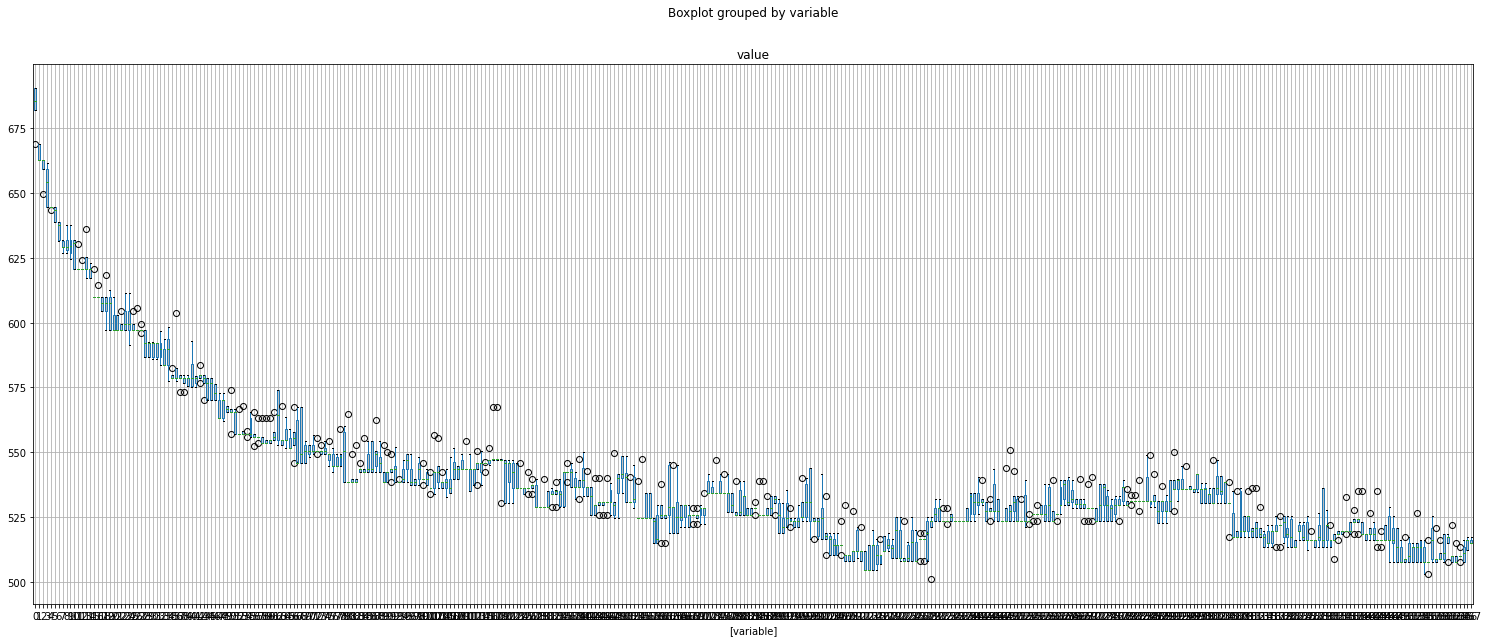

In [131]:
df.loc[((df['variable'] >= 0)&(df['variable'] <= 1000))].boxplot(by='variable')